In [2]:
%load_ext blackcellmagic

In [57]:
from fonctions_perso import sql_request
import pandas as pd
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt


# preprocessing

## `tracking` preprocessing

On récupère les données (exemple sur 2 matchs)

In [4]:
track = sql_request(
    'SELECT * FROM tracking WHERE match_id="Match_001" OR match_id="Match_002" OR match_id="Match_004" OR match_id="Match_005"'
)


In [5]:
(track.head())


time_sec ht  posx  posy      name_id  team_id   date_id   match_id
0       0.0  1   871   909  Player_0088  Team_02  Date_001  Match_001
1       0.1  1   861   909  Player_0088  Team_02  Date_001  Match_001
2       0.2  1   852   910  Player_0088  Team_02  Date_001  Match_001
3       0.3  1   842   911  Player_0088  Team_02  Date_001  Match_001
4       0.4  1   833   913  Player_0088  Team_02  Date_001  Match_001

La colonne `date_id` ne sert à rien, on la vire :

In [6]:
track = track.drop("date_id", axis=1)
track.head()


time_sec ht  posx  posy      name_id  team_id   match_id
0       0.0  1   871   909  Player_0088  Team_02  Match_001
1       0.1  1   861   909  Player_0088  Team_02  Match_001
2       0.2  1   852   910  Player_0088  Team_02  Match_001
3       0.3  1   842   911  Player_0088  Team_02  Match_001
4       0.4  1   833   913  Player_0088  Team_02  Match_001

le point (0, 0) est censé être au centre du stade. vérifions :

In [7]:
(track.loc[:, "posx"].plot(kind="hist"))
(track.loc[:, "posy"].plot(kind="hist"))


ok ça a l'air bon, les X vont de -6000cm à 6000cm et les Y de -4000cm à 4000cm.
ça donne un terrain de 120m x 80m. C'est crédible.

Apparemment nous devons inverser l'axe Y :

In [8]:
track.loc[:, "posy"] = -track.loc[:, "posy"]


Vérifions que ça marche :

In [9]:
(track.head())


time_sec ht  posx  posy      name_id  team_id   match_id
0       0.0  1   871  -909  Player_0088  Team_02  Match_001
1       0.1  1   861  -909  Player_0088  Team_02  Match_001
2       0.2  1   852  -910  Player_0088  Team_02  Match_001
3       0.3  1   842  -911  Player_0088  Team_02  Match_001
4       0.4  1   833  -913  Player_0088  Team_02  Match_001

OK

il faut aussi convertir les X, de manière que le repère change en focntion du sens de l'attaque. Mais le sens de l'attaque dépend de qui a la balle. On le fera donc après la fusion avec la table event.

Nous devons maintenant filtrer les observations : nous ne gardons que celles où time_sec est entier pour pouvoir fusionner avec la table events.

In [10]:
track = track.loc[track.loc[:, "time_sec"].map(lambda fl: fl.is_integer()), :]


Pour faire la fusion avec la table events, il va falloir créer une clef sur laquelle fusionner. On va donc créer un `shot_id` qui sera la concaténation des champs `match_id`, `ht` et `time_sec`.

In [11]:
track.loc[:, "shot_id"] = (
    track.loc[:, "match_id"].str.slice(6)
    + "_"
    + track.loc[:, "ht"].map(str)
    + "_"
    + track.loc[:, "time_sec"].map(int).map(str)
)
track.head()


time_sec ht  posx  posy      name_id  team_id   match_id  shot_id
0        0.0  1   871  -909  Player_0088  Team_02  Match_001  001_1_0
10       1.0  1   778  -934  Player_0088  Team_02  Match_001  001_1_1
20       2.0  1   687  -979  Player_0088  Team_02  Match_001  001_1_2
30       3.0  1   580  -926  Player_0088  Team_02  Match_001  001_1_3
40       4.0  1   452  -672  Player_0088  Team_02  Match_001  001_1_4

La table tracking est prête à merge, passons maintenant au preprocessing des données events

## `events` preprocessing

On récupère les données (exemple sur 2 matchs)

In [12]:
events = sql_request(
    'SELECT * FROM events WHERE match_id="Match_001" OR match_id="Match_002" OR match_id="Match_004" OR match_id="Match_005"'
)
events.head()


period_id  MIN  SEC Name (Event Types)  Outcome  X Coordinates  \
0          2   74   34               Pass        1           56.5   
1          2   74   34               Pass        1           56.5   
2          2   74   34               Pass        1           56.5   
3          2   74   34               Pass        1           56.5   
4          2   74   34               Pass        1           56.5   

   Y Coordinates  Qualifier Type  \
0            9.1             140   
1            9.1              56   
2            9.1             141   
3            9.1             213   
4            9.1             212   

                                         Description Qualifier Value  \
0  The x pitch coordinate for the end point of a ...            68.1   
1                          Back, Left, Center, Right          Center   
2  The y pitch coordinate for the end point of a ...            29.4   
3  The angle the ball travels at during an event ...             0.8   
4  The estimated length the ball has travelled du...            18.4   

    date_id   match_id      name_id  team_id  event_id  
0  Date_001  Match_001  Player_0090  Team_01         1  
1  Date_001  Match_001  Player_0090  Team_01         1  
2  Date_001  Match_001  Player_0090  Team_01         1  
3  Date_001  Match_001  Player_0090  Team_01         1  
4  Date_001  Match_001  Player_0090  Team_01         1

In [13]:
(
    sql_request(
        'SELECT * FROM events WHERE match_id="Match_001" OR match_id="Match_002" OR match_id="Match_004" OR match_id="Match_005"'
    ).query("MIN == 44")
)


period_id  MIN  SEC Name (Event Types)  Outcome  X Coordinates  \
765            1   44   12             Aerial        1           90.1   
766            1   44   12             Aerial        1           90.1   
767            1   44   13               Pass        1           88.5   
768            1   44   13               Pass        1           88.5   
769            1   44   13               Pass        1           88.5   
770            1   44   13               Pass        1           88.5   
771            1   44   13               Pass        1           88.5   
1351           1   44   15      Attempt Saved        1           86.4   
1352           1   44   15      Attempt Saved        1           86.4   
1353           1   44   15      Attempt Saved        1           86.4   
1354           1   44   15      Attempt Saved        1           86.4   
1355           1   44   15      Attempt Saved        1           86.4   
1608           1   44   10               Pass        1           99.5   
1609           1   44   10               Pass        1           99.5   
1610           1   44   10               Pass        1           99.5   
1611           1   44   10               Pass        1           99.5   
1612           1   44   10               Pass        1           99.5   
2482           1   44   18               Miss        1           71.6   
2483           1   44   18               Miss        1           71.6   
2484           1   44   18               Miss        1           71.6   
2485           1   44   18               Miss        1           71.6   
2486           1   44   18               Miss        1           71.6   
2487           1   44   19                Out        0          101.4   
2488           1   44   19                Out        0          101.4   
2840           1   44   51               Pass        1           50.9   
2841           1   44   51               Pass        1           50.9   
2842           1   44   51               Pass        1           50.9   
2843           1   44   51               Pass        1           50.9   
2844           1   44   51               Pass        1           50.9   
2845           1   44   56               Pass        1           62.3   
...          ...  ...  ...                ...      ...            ...   
17351          1   44   35               Pass        1           56.4   
17604          1   44   16               Pass        1           19.8   
17605          1   44   16               Pass        1           19.8   
17606          1   44   16               Pass        1           19.8   
17607          1   44   16               Pass        1           19.8   
17608          1   44   16               Pass        1           19.8   
17922          1   44   23               Pass        1           27.4   
17923          1   44   23               Pass        1           27.4   
17924          1   44   23               Pass        1           27.4   
17925          1   44   23               Pass        1           27.4   
17926          1   44   23               Pass        1           27.4   
19295          1   44   25               Foul        1           34.0   
19296          1   44   25               Foul        1           34.0   
19914          1   44   19          Challenge        0           27.8   
19915          1   44   19          Challenge        0           27.8   
20038          1   44   59               Pass        1           32.2   
20039          1   44   59               Pass        1           32.2   
20040          1   44   59               Pass        1           32.2   
20041          1   44   59               Pass        1           32.2   
20042          1   44   59               Pass        1           32.2   
20460          1   44    3               Pass        0           76.4   
20461          1   44    3               Pass        0           76.4   
20462          1   44    3               Pass        0           

Il y a beaucoup de colonnes inutiles. On les vire :

In [14]:
events = events.drop(
    ["Outcome", "Qualifier Type", "Description", "Qualifier Value", "date_id"], axis=1
)
events.head()


period_id  MIN  SEC Name (Event Types)  X Coordinates  Y Coordinates  \
0          2   74   34               Pass           56.5            9.1   
1          2   74   34               Pass           56.5            9.1   
2          2   74   34               Pass           56.5            9.1   
3          2   74   34               Pass           56.5            9.1   
4          2   74   34               Pass           56.5            9.1   

    match_id      name_id  team_id  event_id  
0  Match_001  Player_0090  Team_01         1  
1  Match_001  Player_0090  Team_01         1  
2  Match_001  Player_0090  Team_01         1  
3  Match_001  Player_0090  Team_01         1  
4  Match_001  Player_0090  Team_01         1

On en profite pour renommer les colonnes qui contiennent des espaces et enlever les majuscules :

In [15]:
events = events.rename(
    columns={
        "MIN": "min",
        "SEC": "sec",
        "Name (Event Types)": "event_type",
        "X Coordinates": "x_opta",
        "Y Coordinates": "y_opta",
    }
)
events.head()


period_id  min  sec event_type  x_opta  y_opta   match_id      name_id  \
0          2   74   34       Pass    56.5     9.1  Match_001  Player_0090   
1          2   74   34       Pass    56.5     9.1  Match_001  Player_0090   
2          2   74   34       Pass    56.5     9.1  Match_001  Player_0090   
3          2   74   34       Pass    56.5     9.1  Match_001  Player_0090   
4          2   74   34       Pass    56.5     9.1  Match_001  Player_0090   

   team_id  event_id  
0  Team_01         1  
1  Team_01         1  
2  Team_01         1  
3  Team_01         1  
4  Team_01         1

On ne garde que les tirs :

In [16]:
events = events.query("event_type in ['Miss', 'Post', 'Attempt Saved', 'Goal']")
events.head()


period_id  min  sec     event_type  x_opta  y_opta   match_id  \
456          1   18   22  Attempt Saved    85.6    67.2  Match_001   
457          1   18   22  Attempt Saved    85.6    67.2  Match_001   
458          1   18   22  Attempt Saved    85.6    67.2  Match_001   
459          1   18   22  Attempt Saved    85.6    67.2  Match_001   
460          1   18   22  Attempt Saved    85.6    67.2  Match_001   

         name_id  team_id  event_id  
456  Player_0044  Team_01      1031  
457  Player_0044  Team_01      1031  
458  Player_0044  Team_01      1031  
459  Player_0044  Team_01      1031  
460  Player_0044  Team_01      1031

On constate qu'il y a des doublons. On les supprime :

In [17]:
events = events.drop_duplicates()
events.head()


period_id  min  sec     event_type  x_opta  y_opta   match_id  \
456           1   18   22  Attempt Saved    85.6    67.2  Match_001   
1351          1   44   15  Attempt Saved    86.4    69.4  Match_001   
1410          2   51   35           Post    81.3    73.9  Match_001   
2231          2   72    4  Attempt Saved    86.6    68.2  Match_001   
2482          1   44   18           Miss    71.6    69.0  Match_001   

          name_id  team_id  event_id  
456   Player_0044  Team_01      1031  
1351  Player_0092  Team_01       252  
1410  Player_0092  Team_01       665  
2231  Player_0087  Team_01      6583  
2482  Player_0021  Team_01       254

Vérifions quand même qu'il n'y ait pas d'event_id en double :

In [18]:
(events.loc[:, "event_id"].value_counts().loc[lambda s: 1 < s])


Series([], Name: event_id, dtype: int64)

OK

Ce qui nous intéresse, c'est de savoir s'il y a eu but ou non. On se fiche de savoir s'il y a eu poteau ou si le gardien l'a arreté etc...
On va donc créer une variable booléenne `goal` et supprimer `event_type` :

In [19]:
events.loc[:, "event_type"] = events.loc[:, "event_type"].map(
    lambda x: True if x == "Goal" else False
)
events = events.rename(columns={"event_type": "goal"})
events.head(10)


period_id  min  sec   goal  x_opta  y_opta   match_id      name_id  \
456           1   18   22  False    85.6    67.2  Match_001  Player_0044   
1351          1   44   15  False    86.4    69.4  Match_001  Player_0092   
1410          2   51   35  False    81.3    73.9  Match_001  Player_0092   
2231          2   72    4  False    86.6    68.2  Match_001  Player_0087   
2482          1   44   18  False    71.6    69.0  Match_001  Player_0021   
2978          1   34   26   True    97.2    53.4  Match_001  Player_0088   
4237          2   48   21  False    70.2    50.3  Match_005  Player_0088   
5050          1   24    2  False    97.9    40.2  Match_002  Player_0036   
5228          2   86   41  False    92.9    48.7  Match_002  Player_0036   
6494          2   63    1  False    86.6    63.0  Match_001  Player_0004   

      team_id  event_id  
456   Team_01      1031  
1351  Team_01       252  
1410  Team_01       665  
2231  Team_01      6583  
2482  Team_01       254  
2978  Team_02       826  
4237  Team_02      7322  
5050  Team_02      1473  
5228  Team_02      2153  
6494  Team_02      6802

In [20]:
events.rename(columns={"event_type": "goal"}).head(10)


period_id  min  sec   goal  x_opta  y_opta   match_id      name_id  \
456           1   18   22  False    85.6    67.2  Match_001  Player_0044   
1351          1   44   15  False    86.4    69.4  Match_001  Player_0092   
1410          2   51   35  False    81.3    73.9  Match_001  Player_0092   
2231          2   72    4  False    86.6    68.2  Match_001  Player_0087   
2482          1   44   18  False    71.6    69.0  Match_001  Player_0021   
2978          1   34   26   True    97.2    53.4  Match_001  Player_0088   
4237          2   48   21  False    70.2    50.3  Match_005  Player_0088   
5050          1   24    2  False    97.9    40.2  Match_002  Player_0036   
5228          2   86   41  False    92.9    48.7  Match_002  Player_0036   
6494          2   63    1  False    86.6    63.0  Match_001  Player_0004   

      team_id  event_id  
456   Team_01      1031  
1351  Team_01       252  
1410  Team_01       665  
2231  Team_01      6583  
2482  Team_01       254  
2978  Team_02       826  
4237  Team_02      7322  
5050  Team_02      1473  
5228  Team_02      2153  
6494  Team_02      6802

On peut maintenant s'atteler à la création du shot_id pour la fusion.
On va commencer par créer time_sec, variable du nombre de secondes écoulées depuis le début de la mi-temps :

In [21]:
events.loc[:, "time_sec"] = (
    events.loc[:, "min"] - 45 * (events.loc[:, "period_id"] - 1)
) * 60 + events.loc[:, "sec"]
events.head()


period_id  min  sec   goal  x_opta  y_opta   match_id      name_id  \
456           1   18   22  False    85.6    67.2  Match_001  Player_0044   
1351          1   44   15  False    86.4    69.4  Match_001  Player_0092   
1410          2   51   35  False    81.3    73.9  Match_001  Player_0092   
2231          2   72    4  False    86.6    68.2  Match_001  Player_0087   
2482          1   44   18  False    71.6    69.0  Match_001  Player_0021   

      team_id  event_id  time_sec  
456   Team_01      1031      1102  
1351  Team_01       252      2655  
1410  Team_01       665       395  
2231  Team_01      6583      1624  
2482  Team_01       254      2658

On peut enfin créé le `shot_id` :

In [22]:
events.loc[:, "shot_id"] = (
    events.loc[:, "match_id"].str.slice(6)
    + "_"
    + events.loc[:, "period_id"].map(str)
    + "_"
    + events.loc[:, "time_sec"].map(str)
)
events.head()


period_id  min  sec   goal  x_opta  y_opta   match_id      name_id  \
456           1   18   22  False    85.6    67.2  Match_001  Player_0044   
1351          1   44   15  False    86.4    69.4  Match_001  Player_0092   
1410          2   51   35  False    81.3    73.9  Match_001  Player_0092   
2231          2   72    4  False    86.6    68.2  Match_001  Player_0087   
2482          1   44   18  False    71.6    69.0  Match_001  Player_0021   

      team_id  event_id  time_sec     shot_id  
456   Team_01      1031      1102  001_1_1102  
1351  Team_01       252      2655  001_1_2655  
1410  Team_01       665       395   001_2_395  
2231  Team_01      6583      1624  001_2_1624  
2482  Team_01       254      2658  001_1_2658

## fusion des tables

Nous sommes presques prêts à fusionner les tables. Avant ceci, nous allons supprimer quleques variables redondantes et en renommmer certaines pour ne pas les confondre :

In [23]:
track = track.drop(["time_sec", "ht", "match_id"], axis=1).rename(
    columns={
        "posx": "x_cm",
        "posy": "y_cm",
        "name_id": "player_id",
        "team_id": "player_team",
    }
)
events = events.drop(["event_id"], axis=1).rename(
    columns={"period_id": "ht", "name_id": "striker_id", "team_id": "striker_team"}
)
track.head()


x_cm  y_cm    player_id player_team  shot_id
0    871  -909  Player_0088     Team_02  001_1_0
10   778  -934  Player_0088     Team_02  001_1_1
20   687  -979  Player_0088     Team_02  001_1_2
30   580  -926  Player_0088     Team_02  001_1_3
40   452  -672  Player_0088     Team_02  001_1_4

In [24]:
events.head()


ht  min  sec   goal  x_opta  y_opta   match_id   striker_id  \
456    1   18   22  False    85.6    67.2  Match_001  Player_0044   
1351   1   44   15  False    86.4    69.4  Match_001  Player_0092   
1410   2   51   35  False    81.3    73.9  Match_001  Player_0092   
2231   2   72    4  False    86.6    68.2  Match_001  Player_0087   
2482   1   44   18  False    71.6    69.0  Match_001  Player_0021   

     striker_team  time_sec     shot_id  
456       Team_01      1102  001_1_1102  
1351      Team_01      2655  001_1_2655  
1410      Team_01       395   001_2_395  
2231      Team_01      1624  001_2_1624  
2482      Team_01      2658  001_1_2658

On peut maintenant procéder à la jointure :

In [25]:
shots = pd.merge(track, events, on="shot_id", how="right", validate="many_to_one")
shots.head()


x_cm  y_cm    player_id player_team    shot_id  ht  min  sec  goal  x_opta  \
0 -3116   576  Player_0088     Team_02  001_1_563   1    9   23  True    85.5   
1 -3187 -1188  Player_0029     Team_02  001_1_563   1    9   23  True    85.5   
2 -2655   400  Player_0056     Team_02  001_1_563   1    9   23  True    85.5   
3 -2571  1498  Player_0004     Team_02  001_1_563   1    9   23  True    85.5   
4  -448  2300  Player_0035     Team_02  001_1_563   1    9   23  True    85.5   

   y_opta   match_id   striker_id striker_team  time_sec  
0    47.3  Match_001  Player_0060      Team_02       563  
1    47.3  Match_001  Player_0060      Team_02       563  
2    47.3  Match_001  Player_0060      Team_02       563  
3    47.3  Match_001  Player_0060      Team_02       563  
4    47.3  Match_001  Player_0060      Team_02       563

In [26]:
(shots.isna().any())


x_cm            False
y_cm            False
player_id       False
player_team     False
shot_id         False
ht              False
min             False
sec             False
goal            False
x_opta          False
y_opta          False
match_id        False
striker_id      False
striker_team    False
time_sec        False
dtype: bool

Parfait, la jointure est faite et il n'y a aucun NA

## Changement de référentiel

Les coordonnées en cm sont dans un repère fixe au cours du temps, alors que le repère des données opta change d'orientation selon le sens de l'attaque (ce qui est l'objectif recherché).

Le but est donc dans un 1er temps de passer les coordonnées en cm dans le référentiel des données opta

Si on suppose qu'un tir est effectué dans la moitié de l'équipe adverse, alors on peut connaître le sens de l'attaque seulement grâce aux coordonnées en cm.
Néanmoins, si un joueur tire depuis sa moitié de terrain, cette méthode ne fonctionne pas. Vérifions si cela est déjà arrivé dans nos données :

In [27]:
(
    sql_request("SELECT * FROM events")
    .rename(columns={"Name (Event Types)": "type"})
    .query("type in ['Miss', 'Post', 'Attempt Saved', 'Goal']")
    .loc[lambda df: df.loc[:, "X Coordinates"] < 50, :]
    .head()
)


Empty DataFrame
Columns: [period_id, MIN, SEC, type, Outcome, X Coordinates, Y Coordinates, Qualifier Type, Description, Qualifier Value, date_id, match_id, name_id, team_id, event_id]
Index: []

Cela n'est pas arrivé, on va donc utiliser cette méthode.

Concrètement, on va marquer tous les tirs pour lesquels le tireur a un x_cm négatif :

In [28]:
shots = shots.groupby("shot_id").apply(
    lambda df1: (
        df1.assign(
            inverted=lambda df2: (
                df2.query("player_id == striker_id").loc[:, "x_cm"].iat[0]
            )
            < 0
        )
    )
)
shots.head(88)


x_cm  y_cm    player_id player_team     shot_id  ht  min  sec  \
shot_id                                                                         
001_1_1102 44   3533   432  Player_0088     Team_02  001_1_1102   1   18   22   
           45   1975 -1354  Player_0029     Team_02  001_1_1102   1   18   22   
           46   3794  1460  Player_0056     Team_02  001_1_1102   1   18   22   
           47   3545  2532  Player_0004     Team_02  001_1_1102   1   18   22   
           48   4274  1513  Player_0035     Team_02  001_1_1102   1   18   22   
           49   5135   203  Player_0034     Team_02  001_1_1102   1   18   22   
           50   3909  1072  Player_0030     Team_02  001_1_1102   1   18   22   
           51   4068   971  Player_0063     Team_02  001_1_1102   1   18   22   
           52    687   210  Player_0060     Team_02  001_1_1102   1   18   22   
           53   4308   452  Player_0036     Team_02  001_1_1102   1   18   22   
           54   4044  -806  Player_0070     Team_02  001_1_1102   1   18   22   
           55   3274  2703  Player_0021     Team_01  001_1_1102   1   18   22   
           56    288  1000  Player_0067     Team_01  001_1_1102   1   18   22   
           57  -2860   322  Player_0040     Team_01  001_1_1102   1   18   22   
           58   4233   536  Player_0087     Team_01  001_1_1102   1   18   22   
           59   2500   208  Player_0079     Team_01  001_1_1102   1   18   22   
           60   3616 -1793  Player_0010     Team_01  001_1_1102   1   18   22   
           61   3888  1172  Player_0044     Team_01  001_1_1102   1   18   22   
           62   1233  1783  Player_0025     Team_01  001_1_1102   1   18   22   
           63     98  -180  Player_0005     Team_01  001_1_1102   1   18   22   
           64   4514  1648  Player_0092     Team_01  001_1_1102   1   18   22   
           65    213 -1384  Player_0090     Team_01  001_1_1102   1   18   22   
001_1_1231 66  -2064 -1169  Player_0088     Team_02  001_1_1231   1   20   31   
           67  -4567 -1575  Player_0029     Team_02  001_1_1231   1   20   31   
           68  -2950   146  Player_0056     Team_02  001_1_1231   1   20   31   
           69  -4418   658  Player_0004     Team_02  001_1_1231   1   20   31   
           70  -1986  1305  Player_0035     Team_02  001_1_1231   1   20   31   
           71   2024  -154  Player_0034     Team_02  001_1_1231   1   20   31   
           72  -2354 -2229  Player_0030     Team_02  001_1_1231   1   20   31   
           73   -808  -190  Player_0063     Team_02  001_1_1231   1   20   31   
...              ...   ...          ...         ...         ...  ..  ...  ...   
001_1_2066 102   373  -154  Player_0087     Team_01  001_1_2066   1   34   26   
           103 -3341  -519  Player_0079     Team_01  001_1_2066   1   34   26   
           104 -1243  2777  Player_0010     Team_01  001_1_2066   1   34   26   
           105  -259 -1232  Player_0044     Team_01  001_1_2066   1   34   26   
           106 -3859   -26  Player_0025     Team_01  001_1_2066   1   34   26   
           107 -4854   317  Player_0005     Team_01  001_1_2066   1   34   26   
           108 -5194  -279  Player_0092     Team_01  001_1_2066   1   34   26   
           109 -4816  -544  Player_0090     Team_01  001_1_2066   1   34   26   
001_1_2655 110  4652  -390  Player_0088     Team_02  001_1_2655   1   44   15   
           111  3737  -856  Player_0029     Team_02  001_1_2655   1   44   15   
           112  4548   178  Player_0056     Team_02  001_1_2655   1   44   15   
           113  4109   256  Player_0004     Team_02  001_1_2655   1   44   15   
           114  4038   525  Player_0035     Team_02  001_1_2655   1   44   15   
           115  5042   135  Player_0034     Team_02  001_1_2655   1   44   15   
           116  4260   950  Player_0030     Team_02  001_1_2655   1   44   15   
           117  4373   497  Player_0063     Team_02  001_1_2655   1   44   15   
           118  3774  1210  Player_0060     Tea

Vérifions :

In [29]:
(shots.query("player_id == striker_id").sort_values("x_cm"))


x_cm  y_cm    player_id player_team     shot_id  ht  min  \
shot_id                                                                     
001_1_2066 88   -5269  -230  Player_0088     Team_02  001_1_2066   1   34   
002_2_1981 881  -4828  -831  Player_0029     Team_02  002_2_1981   2   78   
004_2_2800 1416 -4769  -235  Player_0031     Team_02  004_2_2800   2   91   
004_1_1073 1049 -4646   870  Player_0068     Team_05  004_1_1073   1   17   
001_1_1231 67   -4567 -1575  Player_0029     Team_02  001_1_1231   1   20   
002_1_2853 678  -4528 -1154  Player_0086     Team_06  002_1_2853   1   47   
004_2_1890 1303 -4488   812  Player_0053     Team_02  004_2_1890   2   76   
004_2_830  1172 -4434   508  Player_0053     Team_02   004_2_830   2   58   
002_2_93   727  -4422 -1052  Player_0029     Team_02    002_2_93   2   46   
002_1_783  460  -4348   237  Player_0059     Team_06   002_1_783   1   13   
002_1_782  437  -4342  -820  Player_0055     Team_06   002_1_782   1   13   
002_2_2501 931  -4319    45  Player_0036     Team_02  002_2_2501   2   86   
002_2_2183 911  -4301  -767  Player_0053     Team_02  002_2_2183   2   81   
002_2_92   705  -4169 -1245  Player_0029     Team_02    002_2_92   2   46   
002_2_433  755  -4156    23  Player_0060     Team_02   002_2_433   2   52   
005_1_93   1432 -4070   912  Player_0032     Team_02    005_1_93   1    1   
002_1_1166 548  -3928  -318  Player_0059     Team_06  002_1_1166   1   19   
002_2_772  793  -3890 -1623  Player_0029     Team_02   002_2_772   2   57   
001_2_1624 255  -3882 -1107  Player_0087     Team_01  001_2_1624   2   72   
001_1_563  8    -3791   246  Player_0060     Team_02   001_1_563   1    9   
002_1_1364 570  -3696  -434  Player_0059     Team_06  002_1_1364   1   22   
002_2_556  771  -3692   852  Player_0029     Team_02   002_2_556   2   54   
004_1_2760 1112 -3675 -1061  Player_0072     Team_05  004_1_2760   1   46   
002_1_1859 606  -3599  -467  Player_0051     Team_06  002_1_1859   1   30   
002_1_1869 628  -3597   218  Player_0051     Team_06  002_1_1869   1   31   
005_1_1434 1519 -3593  -102  Player_0029     Team_02  005_1_1434   1   23   
002_2_865  823  -3565   344  Player_0053     Team_02   002_2_865   2   59   
004_1_438  985  -3465 -2409  Player_0054     Team_05   004_1_438   1    7   
002_2_2674 955  -3434 -1378  Player_0053     Team_02  002_2_2674   2   89   
001_2_395  174  -3340 -1546  Player_0092     Team_01   001_2_395   2   51   
...               ...   ...          ...         ...         ...  ..  ...   
005_2_2010 1697  3023  -526  Player_0032     Team_02  005_2_2010   2   78   
001_2_2140 294   3084  -326  Player_0060     Team_02  001_2_2140   2   80   
005_1_267  1472  3113  1470  Player_0046     Team_03   005_1_267   1    4   
004_2_1054 1200  3190   595  Player_0009     Team_05  004_2_1054   2   62   
002_1_292  397   3221 -1632  Player_0029     Team_02   002_1_292   1    4   
005_1_1979 1551  3364 -1758  Player_0050     Team_03  005_1_1979   1   32   
001_1_2655 130   3698  1791  Player_0092     Team_01  001_1_2655   1   44   
005_2_303  1635  3709   388  Player_0031     Team_02   005_2_303   2   50   
005_2_603  1653  3715  1777  Player_0083     Team_02   005_2_603   2   55   
005_2_997  1673  3784  -251  Player_0029     Team_02   005_2_997   2   61   
004_1_615  996   3837   566  Player_0053     Team_02   004_1_615   1   10   
004_2_1874 1293  3852   566  Player_0054     Team_05  004_2_1874   2   76   
001_1_1102 61    3888  1172  Player_0044     Team_01  001_1_1102   1   18   
004_2_2444 1359  3948  -920  Player_0054     Team_05  004_2_2444   2   85   
001_2_1700 272   3985   455  Player_0060     Team_02  001_2_1700   2   73   
004_2_1523 1230  4038   124  Player_0074     Team_05  004_2_1523   2   70   
004_1_2124 1059  4084   286  Player_0060     Team_02  004_1_2124   1   35   
005_1_1099 1509  4136    86  Player_0038     Team_03  005_1_1099   1   18   
001_2_1081 201   4153  1122  Player_0004     Team_02  001_2_1081   2   63   
004_2_1685 12

Pour chaque tir dans le sens "inversé", nous voulons faire une symétrie centrale des positions des joueurs par rapport au centre du terrain :

In [30]:
shots.loc[shots.loc[:, "inverted"], "x_cm"] = -shots.loc[
    shots.loc[:, "inverted"], "x_cm"
]

shots.loc[shots.loc[:, "inverted"], "y_cm"] = -shots.loc[
    shots.loc[:, "inverted"], "y_cm"
]


Vérifions ce que ça donne si on plot les positiosn des tirs

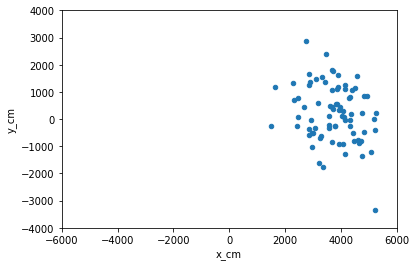

In [31]:
(
    shots.query("player_id == striker_id").plot.scatter(
        "x_cm", "y_cm", xlim=(-6000, 6000), ylim=(-4000, 4000)
    )
)


Nickel

## Changement de repère

Nous allons maintenant changer les coordonnées de repère, en déplaçant l'origine au centre des cages et en inversant l'axe.
Concrètement on veut soustraire la distance "ligne médiane - centre des cages" au x de chaque ligne, et inverser le signe.

Cependant cette distance varie selon les matchs. On va donc grouper le traitement par match, et calculer cette distance grâce à une règle de trois et les coordonnées opta.

Soient :
* $d$ la distance ligne médiane - centre des cages.
* $x_{cm}$ le x dans le repère ayant pour origine le centre du terrain
* $x_{opta}$ le x dans le repère opta
* $p$ le nombre par lequel on doit multiplier un x opta pour avoir la distance en cm réels

On a :
$$d = 50\cdot p$$
donc
$$p = 0,02\cdot d$$

De plus,
$$d + x_{cm} = x_{opta}\cdot p$$ 
donc 
$$d + x_{cm} = 0,02\cdot d\cdot x_{opta}$$
$$d\cdot (1 - 0,02\cdot x_{opta}) = - x_{cm}$$
$$d = - \frac{x_{cm}}{1 - 0,02\cdot x_{opta}}$$
$$d = \frac{x_{cm}}{0,02\cdot x_{opta} - 1}$$

Donc, pour un match donné, on rempace $x_{cm}$ par :
$$d - x_{cm} = \frac{x_{cm}}{0,02\cdot x_{opta} - 1} - x_{cm}$$

In [32]:
shots = (
    shots.reset_index(drop=True)
    .groupby("shot_id")
    .apply(
        lambda df1: (
            df1.assign(
                half_field=(
                    lambda df2: df2.query("player_id == striker_id").pipe(
                        lambda df3: (
                            df3.loc[:, "x_cm"] / (0.02 * df3.loc[:, "x_opta"] - 1)
                        ).iat[0]
                    )
                )
            ).assign(x_cm=lambda df2: df2.loc[:, "half_field"] - df2.loc[:, "x_cm"])
        )
    )
)


On vérifie en plottant les tirs

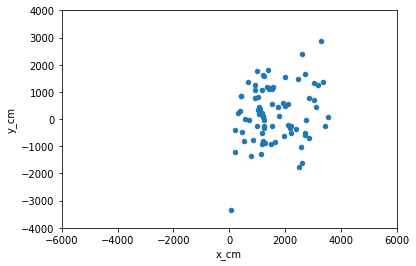

In [33]:
(
    shots.query("player_id == striker_id").plot.scatter(
        "x_cm", "y_cm", xlim=(-6000, 6000), ylim=(-4000, 4000)
    )
)


C'est la même figure que plus haut donc c'est bon

On en profite pour convertir les coordonnées en mètres, et inverser les axes, de manière que X représente la largeur du terrain et Y la longueur comme suit :
![title](canvas.png)

In [34]:
shots.loc[:, "x_cm"] = shots.loc[:, "x_cm"] / 100
shots.loc[:, "y_cm"] = shots.loc[:, "y_cm"] / 100
shots = shots.rename(columns={"x_cm": "player_y", "y_cm": "player_x"})


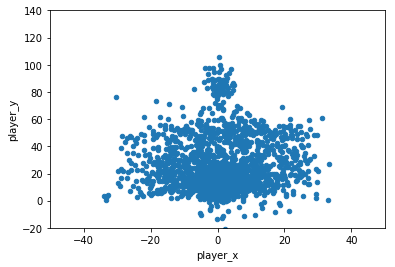

In [35]:
(
    shots
    # .query("player_id == striker_id")
    .plot.scatter("player_x", "player_y", xlim=(-50, 50), ylim=(-20, 140))
)


## features

Maintenant que notre base dedonnées est prête, on va rajouter nos features

### coordonnées cartésiennes

In [36]:
shots = (
    shots.reset_index(drop=True)
    .groupby("shot_id")
    .apply(
        lambda df1: (
            df1.assign(
                striker_x=lambda df2: (
                    df2.query("player_id == striker_id").loc[:, "player_x"].iat[0]
                ),
                striker_y=lambda df2: (
                    df2.query("player_id == striker_id").loc[:, "player_y"].iat[0]
                ),
            )
        )
    )
)
shots.head()


player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                      
001_1_1102 0  19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1  34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2  16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3  19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4  11.866742     15.13  Player_0035     Team_02  001_1_1102   1   

              min  sec   goal  x_opta  y_opta   match_id   striker_id  \
shot_id                                                                 
001_1_1102 0   18   22  False    85.6    67.2  Match_001  Player_0044   
           1   18   22  False    85.6    67.2  Match_001  Player_0044   
           2   18   22  False    85.6    67.2  Match_001  Player_0044   
           3   18   22  False    85.6    67.2  Match_001  Player_0044   
           4   18   22  False    85.6    67.2  Match_001  Player_0044   

             striker_team  time_sec  inverted   half_field  striker_x  \
shot_id                                                                 
001_1_1102 0      Team_01      1102     False  5460.674157      11.72   
           1      Team_01      1102     False  5460.674157      11.72   
           2      Team_01      1102     False  5460.674157      11.72   
           3      Team_01      1102     False  5460.674157      11.72   
           4      Team_01      1102     False  5460.674157      11.72   

              striker_y  
shot_id                  
001_1_1102 0  15.726742  
           1  15.726742  
           2  15.726742  
           3  15.726742  
           4  15.726742

### coordonnées polaires

On rajoute ensuite les coordonnées polaires pour chaque joueur :

In [37]:
shots.loc[:, "player_theta"] = np.arctan2(
    shots.loc[:, "player_y"], shots.loc[:, "player_x"]
)
shots.head()


player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                      
001_1_1102 0  19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1  34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2  16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3  19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4  11.866742     15.13  Player_0035     Team_02  001_1_1102   1   

              min  sec   goal  x_opta  y_opta   match_id   striker_id  \
shot_id                                                                 
001_1_1102 0   18   22  False    85.6    67.2  Match_001  Player_0044   
           1   18   22  False    85.6    67.2  Match_001  Player_0044   
           2   18   22  False    85.6    67.2  Match_001  Player_0044   
           3   18   22  False    85.6    67.2  Match_001  Player_0044   
           4   18   22  False    85.6    67.2  Match_001  Player_0044   

             striker_team  time_sec  inverted   half_field  striker_x  \
shot_id                                                                 
001_1_1102 0      Team_01      1102     False  5460.674157      11.72   
           1      Team_01      1102     False  5460.674157      11.72   
           2      Team_01      1102     False  5460.674157      11.72   
           3      Team_01      1102     False  5460.674157      11.72   
           4      Team_01      1102     False  5460.674157      11.72   

              striker_y  player_theta  
shot_id                                
001_1_1102 0  15.726742      1.350335  
           1  15.726742      1.941304  
           2  15.726742      0.851402  
           3  15.726742      0.647702  
           4  15.726742      0.665106

In [38]:
shots.loc[:, "player_dist_to_goal"] = np.sqrt(
    np.square(shots.loc[:, "player_x"]) + np.square(shots.loc[:, "player_y"])
)
shots.head()


player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                      
001_1_1102 0  19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1  34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2  16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3  19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4  11.866742     15.13  Player_0035     Team_02  001_1_1102   1   

              min  sec   goal  x_opta  ...   match_id   striker_id  \
shot_id                                ...                           
001_1_1102 0   18   22  False    85.6  ...  Match_001  Player_0044   
           1   18   22  False    85.6  ...  Match_001  Player_0044   
           2   18   22  False    85.6  ...  Match_001  Player_0044   
           3   18   22  False    85.6  ...  Match_001  Player_0044   
           4   18   22  False    85.6  ...  Match_001  Player_0044   

             striker_team time_sec  inverted   half_field  striker_x  \
shot_id                                                                
001_1_1102 0      Team_01     1102     False  5460.674157      11.72   
           1      Team_01     1102     False  5460.674157      11.72   
           2      Team_01     1102     False  5460.674157      11.72   
           3      Team_01     1102     False  5460.674157      11.72   
           4      Team_01     1102     False  5460.674157      11.72   

              striker_y  player_theta  player_dist_to_goal  
shot_id                                                     
001_1_1102 0  15.726742      1.350335            19.754877  
           1  15.726742      1.941304            37.394171  
           2  15.726742      0.851402            22.157172  
           3  15.726742      0.647702            31.750325  
           4  15.726742      0.665106            19.228532  

[5 rows x 21 columns]

## distance tireur-goal

on marque tout d'abord les joueurs qui sont goals

In [39]:
shots = shots.assign(
    is_gk=lambda df: df.loc[:, "player_id"].isin(
        [
            "Player_0040",
            "Player_0034",
            "Player_0013",
            "Player_0043",
            "Player_0042",
            "Player_0011",
            "Player_0080",
        ]
    )
)
shots.head(11)


player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                       
001_1_1102 0   19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1   34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2   16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3   19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4   11.866742     15.13  Player_0035     Team_02  001_1_1102   1   
           5    3.256742      2.03  Player_0034     Team_02  001_1_1102   1   
           6   15.516742     10.72  Player_0030     Team_02  001_1_1102   1   
           7   13.926742      9.71  Player_0063     Team_02  001_1_1102   1   
           8   47.736742      2.10  Player_0060     Team_02  001_1_1102   1   
           9   11.526742      4.52  Player_0036     Team_02  001_1_1102   1   
           10  14.166742     -8.06  Player_0070     Team_02  001_1_1102   1   

               min  sec   goal  x_opta  ...   striker_id striker_team  \
shot_id                                 ...                             
001_1_1102 0    18   22  False    85.6  ...  Player_0044      Team_01   
           1    18   22  False    85.6  ...  Player_0044      Team_01   
           2    18   22  False    85.6  ...  Player_0044      Team_01   
           3    18   22  False    85.6  ...  Player_0044      Team_01   
           4    18   22  False    85.6  ...  Player_0044      Team_01   
           5    18   22  False    85.6  ...  Player_0044      Team_01   
           6    18   22  False    85.6  ...  Player_0044      Team_01   
           7    18   22  False    85.6  ...  Player_0044      Team_01   
           8    18   22  False    85.6  ...  Player_0044      Team_01   
           9    18   22  False    85.6  ...  Player_0044      Team_01   
           10   18   22  False    85.6  ...  Player_0044      Team_01   

              time_sec inverted   half_field  striker_x  striker_y  \
shot_id                                                              
001_1_1102 0      1102    False  5460.674157      11.72  15.726742   
           1      1102    False  5460.674157      11.72  15.726742   
           2      1102    False  5460.674157      11.72  15.726742   
           3      1102    False  5460.674157      11.72  15.726742   
           4      1102    False  5460.674157      11.72  15.726742   
           5      1102    False  5460.674157      11.72  15.726742   
           6      1102    False  5460.674157      11.72  15.726742   
           7      1102    False  5460.674157      11.72  15.726742   
           8      1102    False  5460.674157      11.72  15.726742   
           9      1102    False  5460.674157      11.72  15.726742   
           10     1102    False  5460.674157      11.72  15.726742   

               player_theta  player_dist_to_goal  is_gk  
shot_id                                                  
001_1_1102 0       1.350335            19.754877  False  
           1       1.941304            37.394171  False  
           2       0.851402            22.157172  False  
           3       0.647702            31.750325  False  
           4       0.665106            19.228532  False  
           5       1.013404             3.837612   True  
           6       0.966226            18.859684  False  
           7       0.961939            16.977580  False  
           8       1.526833            47.782910  False  
           9       1.197091            12.381283  False  
           10      2.088063            16.299085  False  

[11 rows x 22 columns]

on marque ensuite le goal de l'équipe opposée

In [40]:
shots = shots.assign(
    is_opposing_gk=lambda df: (df.loc[:, "player_team"] != df.loc[:, "striker_team"])
    & df.loc[:, "is_gk"]
)
shots.head(22)


player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                       
001_1_1102 0   19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1   34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2   16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3   19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4   11.866742     15.13  Player_0035     Team_02  001_1_1102   1   
           5    3.256742      2.03  Player_0034     Team_02  001_1_1102   1   
           6   15.516742     10.72  Player_0030     Team_02  001_1_1102   1   
           7   13.926742      9.71  Player_0063     Team_02  001_1_1102   1   
           8   47.736742      2.10  Player_0060     Team_02  001_1_1102   1   
           9   11.526742      4.52  Player_0036     Team_02  001_1_1102   1   
           10  14.166742     -8.06  Player_0070     Team_02  001_1_1102   1   
           11  21.866742     27.03  Player_0021     Team_01  001_1_1102   1   
           12  51.726742     10.00  Player_0067     Team_01  001_1_1102   1   
           13  83.206742      3.22  Player_0040     Team_01  001_1_1102   1   
           14  12.276742      5.36  Player_0087     Team_01  001_1_1102   1   
           15  29.606742      2.08  Player_0079     Team_01  001_1_1102   1   
           16  18.446742    -17.93  Player_0010     Team_01  001_1_1102   1   
           17  15.726742     11.72  Player_0044     Team_01  001_1_1102   1   
           18  42.276742     17.83  Player_0025     Team_01  001_1_1102   1   
           19  53.626742     -1.80  Player_0005     Team_01  001_1_1102   1   
           20   9.466742     16.48  Player_0092     Team_01  001_1_1102   1   
           21  52.476742    -13.84  Player_0090     Team_01  001_1_1102   1   

               min  sec   goal  x_opta  ...  striker_team time_sec inverted  \
shot_id                                 ...                                   
001_1_1102 0    18   22  False    85.6  ...       Team_01     1102    False   
           1    18   22  False    85.6  ...       Team_01     1102    False   
           2    18   22  False    85.6  ...       Team_01     1102    False   
           3    18   22  False    85.6  ...       Team_01     1102    False   
           4    18   22  False    85.6  ...       Team_01     1102    False   
           5    18   22  False    85.6  ...       Team_01     1102    False   
           6    18   22  False    85.6  ...       Team_01     1102    False   
           7    18   22  False    85.6  ...       Team_01     1102    False   
           8    18   22  False    85.6  ...       Team_01     1102    False   
           9    18   22  False    85.6  ...       Team_01     1102    False   
           10   18   22  False    85.6  ...       Team_01     1102    False   
           11   18   22  False    85.6  ...       Team_01     1102    False   
           12   18   22  False    85.6  ...       Team_01     1102    False   
           13   18   22  False    85.6  ...       Team_01     1102    False   
           14   18   22  False    85.6  ...       Team_01     1102    False   
           15   18   22  False    85.6  ...       Team_01     1102    False   
           16   18   22  False    85.6  ...       Team_01     1102    False   
           17   18   22  False    85.6  ...       Team_01     1102    False   
           18   18   22  False    85.6  ...       Team_01     1102    False   
           19   18   22  False    85.6  ...       Team_01     1102    False   
           20   18   22  False    85.6  ...       Team_01     1102    False   
           21   18   22  False    85.6  ...       Team_01     1102    False   

                half_field  striker_x  striker_y  player_theta  \
shot_id                                                          
001_1_1102 0   5460.674157      11.72  15.726742      1.350335   
           1   5460.6741

On calcule la distance de chaque joueur au tireur

In [41]:
shots = (
    shots.reset_index(drop=True)
    .groupby("shot_id")
    .apply(
        lambda df1: (
            df1.assign(
                dist_to_striker=lambda df2: np.sqrt(
                    np.square(df2.loc[:, "striker_x"] - df2.loc[:, "player_x"])
                    + np.square(df2.loc[:, "striker_y"] - df2.loc[:, "player_y"])
                )
            )
        )
    )
)

shots.head(22)

player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                       
001_1_1102 0   19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1   34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2   16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3   19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4   11.866742     15.13  Player_0035     Team_02  001_1_1102   1   
           5    3.256742      2.03  Player_0034     Team_02  001_1_1102   1   
           6   15.516742     10.72  Player_0030     Team_02  001_1_1102   1   
           7   13.926742      9.71  Player_0063     Team_02  001_1_1102   1   
           8   47.736742      2.10  Player_0060     Team_02  001_1_1102   1   
           9   11.526742      4.52  Player_0036     Team_02  001_1_1102   1   
           10  14.166742     -8.06  Player_0070     Team_02  001_1_1102   1   
           11  21.866742     27.03  Player_0021     Team_01  001_1_1102   1   
           12  51.726742     10.00  Player_0067     Team_01  001_1_1102   1   
           13  83.206742      3.22  Player_0040     Team_01  001_1_1102   1   
           14  12.276742      5.36  Player_0087     Team_01  001_1_1102   1   
           15  29.606742      2.08  Player_0079     Team_01  001_1_1102   1   
           16  18.446742    -17.93  Player_0010     Team_01  001_1_1102   1   
           17  15.726742     11.72  Player_0044     Team_01  001_1_1102   1   
           18  42.276742     17.83  Player_0025     Team_01  001_1_1102   1   
           19  53.626742     -1.80  Player_0005     Team_01  001_1_1102   1   
           20   9.466742     16.48  Player_0092     Team_01  001_1_1102   1   
           21  52.476742    -13.84  Player_0090     Team_01  001_1_1102   1   

               min  sec   goal  x_opta  ...  time_sec inverted   half_field  \
shot_id                                 ...                                   
001_1_1102 0    18   22  False    85.6  ...      1102    False  5460.674157   
           1    18   22  False    85.6  ...      1102    False  5460.674157   
           2    18   22  False    85.6  ...      1102    False  5460.674157   
           3    18   22  False    85.6  ...      1102    False  5460.674157   
           4    18   22  False    85.6  ...      1102    False  5460.674157   
           5    18   22  False    85.6  ...      1102    False  5460.674157   
           6    18   22  False    85.6  ...      1102    False  5460.674157   
           7    18   22  False    85.6  ...      1102    False  5460.674157   
           8    18   22  False    85.6  ...      1102    False  5460.674157   
           9    18   22  False    85.6  ...      1102    False  5460.674157   
           10   18   22  False    85.6  ...      1102    False  5460.674157   
           11   18   22  False    85.6  ...      1102    False  5460.674157   
           12   18   22  False    85.6  ...      1102    False  5460.674157   
           13   18   22  False    85.6  ...      1102    False  5460.674157   
           14   18   22  False    85.6  ...      1102    False  5460.674157   
           15   18   22  False    85.6  ...      1102    False  5460.674157   
           16   18   22  False    85.6  ...      1102    False  5460.674157   
           17   18   22  False    85.6  ...      1102    False  5460.674157   
           18   18   22  False    85.6  ...      1102    False  5460.674157   
           19   18   22  False    85.6  ...      1102    False  5460.674157   
           20   18   22  False    85.6  ...      1102    False  5460.674157   
           21   18   22  False    85.6  ...      1102    False  5460.674157   

              striker_x  striker_y  player_theta  player_dist_to_goal  is_gk  \
shot_id                                                                        
001_1_1102 0      11.72  15.726742      1.350335            19

on peut maintenant trouver la distance tireur-goal...

In [42]:
shots = (
    shots.reset_index(drop=True)
    .groupby("shot_id")
    .apply(
        lambda df1: (
            df1.assign(
                dist_st_to_gk=lambda df2: (
                    df2.query("is_opposing_gk").loc[:, "dist_to_striker"].iat[0]
                )
            )
        )
    )
)
shots.head(22)


player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                       
001_1_1102 0   19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1   34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2   16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3   19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4   11.866742     15.13  Player_0035     Team_02  001_1_1102   1   
           5    3.256742      2.03  Player_0034     Team_02  001_1_1102   1   
           6   15.516742     10.72  Player_0030     Team_02  001_1_1102   1   
           7   13.926742      9.71  Player_0063     Team_02  001_1_1102   1   
           8   47.736742      2.10  Player_0060     Team_02  001_1_1102   1   
           9   11.526742      4.52  Player_0036     Team_02  001_1_1102   1   
           10  14.166742     -8.06  Player_0070     Team_02  001_1_1102   1   
           11  21.866742     27.03  Player_0021     Team_01  001_1_1102   1   
           12  51.726742     10.00  Player_0067     Team_01  001_1_1102   1   
           13  83.206742      3.22  Player_0040     Team_01  001_1_1102   1   
           14  12.276742      5.36  Player_0087     Team_01  001_1_1102   1   
           15  29.606742      2.08  Player_0079     Team_01  001_1_1102   1   
           16  18.446742    -17.93  Player_0010     Team_01  001_1_1102   1   
           17  15.726742     11.72  Player_0044     Team_01  001_1_1102   1   
           18  42.276742     17.83  Player_0025     Team_01  001_1_1102   1   
           19  53.626742     -1.80  Player_0005     Team_01  001_1_1102   1   
           20   9.466742     16.48  Player_0092     Team_01  001_1_1102   1   
           21  52.476742    -13.84  Player_0090     Team_01  001_1_1102   1   

               min  sec   goal  x_opta  ...  inverted   half_field striker_x  \
shot_id                                 ...                                    
001_1_1102 0    18   22  False    85.6  ...     False  5460.674157     11.72   
           1    18   22  False    85.6  ...     False  5460.674157     11.72   
           2    18   22  False    85.6  ...     False  5460.674157     11.72   
           3    18   22  False    85.6  ...     False  5460.674157     11.72   
           4    18   22  False    85.6  ...     False  5460.674157     11.72   
           5    18   22  False    85.6  ...     False  5460.674157     11.72   
           6    18   22  False    85.6  ...     False  5460.674157     11.72   
           7    18   22  False    85.6  ...     False  5460.674157     11.72   
           8    18   22  False    85.6  ...     False  5460.674157     11.72   
           9    18   22  False    85.6  ...     False  5460.674157     11.72   
           10   18   22  False    85.6  ...     False  5460.674157     11.72   
           11   18   22  False    85.6  ...     False  5460.674157     11.72   
           12   18   22  False    85.6  ...     False  5460.674157     11.72   
           13   18   22  False    85.6  ...     False  5460.674157     11.72   
           14   18   22  False    85.6  ...     False  5460.674157     11.72   
           15   18   22  False    85.6  ...     False  5460.674157     11.72   
           16   18   22  False    85.6  ...     False  5460.674157     11.72   
           17   18   22  False    85.6  ...     False  5460.674157     11.72   
           18   18   22  False    85.6  ...     False  5460.674157     11.72   
           19   18   22  False    85.6  ...     False  5460.674157     11.72   
           20   18   22  False    85.6  ...     False  5460.674157     11.72   
           21   18   22  False    85.6  ...     False  5460.674157     11.72   

               striker_y  player_theta  player_dist_to_goal  is_gk  \
shot_id                                                              
001_1_1102 0   15.726742      1.350335            19.75487

### distance du plus proche défenseur

pour la distance du plus proche défenseur, on va d'abord créer une variable booléenne `is_defender`

In [43]:
shots.loc[:, "is_defender"] = (
    shots.loc[:, "striker_team"] != shots.loc[:, "player_team"]
)
shots.head(22)


player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                       
001_1_1102 0   19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1   34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2   16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3   19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4   11.866742     15.13  Player_0035     Team_02  001_1_1102   1   
           5    3.256742      2.03  Player_0034     Team_02  001_1_1102   1   
           6   15.516742     10.72  Player_0030     Team_02  001_1_1102   1   
           7   13.926742      9.71  Player_0063     Team_02  001_1_1102   1   
           8   47.736742      2.10  Player_0060     Team_02  001_1_1102   1   
           9   11.526742      4.52  Player_0036     Team_02  001_1_1102   1   
           10  14.166742     -8.06  Player_0070     Team_02  001_1_1102   1   
           11  21.866742     27.03  Player_0021     Team_01  001_1_1102   1   
           12  51.726742     10.00  Player_0067     Team_01  001_1_1102   1   
           13  83.206742      3.22  Player_0040     Team_01  001_1_1102   1   
           14  12.276742      5.36  Player_0087     Team_01  001_1_1102   1   
           15  29.606742      2.08  Player_0079     Team_01  001_1_1102   1   
           16  18.446742    -17.93  Player_0010     Team_01  001_1_1102   1   
           17  15.726742     11.72  Player_0044     Team_01  001_1_1102   1   
           18  42.276742     17.83  Player_0025     Team_01  001_1_1102   1   
           19  53.626742     -1.80  Player_0005     Team_01  001_1_1102   1   
           20   9.466742     16.48  Player_0092     Team_01  001_1_1102   1   
           21  52.476742    -13.84  Player_0090     Team_01  001_1_1102   1   

               min  sec   goal  x_opta  ...   half_field striker_x  striker_y  \
shot_id                                 ...                                     
001_1_1102 0    18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           1    18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           2    18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           3    18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           4    18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           5    18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           6    18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           7    18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           8    18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           9    18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           10   18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           11   18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           12   18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           13   18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           14   18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           15   18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           16   18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           17   18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           18   18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           19   18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           20   18   22  False    85.6  ...  5460.674157     11.72  15.726742   
           21   18   22  False    85.6  ...  5460.674157     11.72  15.726742   

              player_theta  player_dist_to_goal  is_gk  is_opposing_gk  \
shot_id                                                                  
001_1_1102 0      1.350335

on peut maintenant calculer la distance au plus proche défenseur :

In [44]:
shots = (
    shots.reset_index(drop=True)
    .groupby("shot_id")
    .apply(
        lambda df1: (
            df1.assign(
                closest_def=(
                    lambda df2: (
                        df2.query("is_defender").loc[:, "dist_to_striker"].min()
                    )
                )
            )
        )
    )
)
shots.head(22)

player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                       
001_1_1102 0   19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1   34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2   16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3   19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4   11.866742     15.13  Player_0035     Team_02  001_1_1102   1   
           5    3.256742      2.03  Player_0034     Team_02  001_1_1102   1   
           6   15.516742     10.72  Player_0030     Team_02  001_1_1102   1   
           7   13.926742      9.71  Player_0063     Team_02  001_1_1102   1   
           8   47.736742      2.10  Player_0060     Team_02  001_1_1102   1   
           9   11.526742      4.52  Player_0036     Team_02  001_1_1102   1   
           10  14.166742     -8.06  Player_0070     Team_02  001_1_1102   1   
           11  21.866742     27.03  Player_0021     Team_01  001_1_1102   1   
           12  51.726742     10.00  Player_0067     Team_01  001_1_1102   1   
           13  83.206742      3.22  Player_0040     Team_01  001_1_1102   1   
           14  12.276742      5.36  Player_0087     Team_01  001_1_1102   1   
           15  29.606742      2.08  Player_0079     Team_01  001_1_1102   1   
           16  18.446742    -17.93  Player_0010     Team_01  001_1_1102   1   
           17  15.726742     11.72  Player_0044     Team_01  001_1_1102   1   
           18  42.276742     17.83  Player_0025     Team_01  001_1_1102   1   
           19  53.626742     -1.80  Player_0005     Team_01  001_1_1102   1   
           20   9.466742     16.48  Player_0092     Team_01  001_1_1102   1   
           21  52.476742    -13.84  Player_0090     Team_01  001_1_1102   1   

               min  sec   goal  x_opta  ...  striker_x  striker_y  \
shot_id                                 ...                         
001_1_1102 0    18   22  False    85.6  ...      11.72  15.726742   
           1    18   22  False    85.6  ...      11.72  15.726742   
           2    18   22  False    85.6  ...      11.72  15.726742   
           3    18   22  False    85.6  ...      11.72  15.726742   
           4    18   22  False    85.6  ...      11.72  15.726742   
           5    18   22  False    85.6  ...      11.72  15.726742   
           6    18   22  False    85.6  ...      11.72  15.726742   
           7    18   22  False    85.6  ...      11.72  15.726742   
           8    18   22  False    85.6  ...      11.72  15.726742   
           9    18   22  False    85.6  ...      11.72  15.726742   
           10   18   22  False    85.6  ...      11.72  15.726742   
           11   18   22  False    85.6  ...      11.72  15.726742   
           12   18   22  False    85.6  ...      11.72  15.726742   
           13   18   22  False    85.6  ...      11.72  15.726742   
           14   18   22  False    85.6  ...      11.72  15.726742   
           15   18   22  False    85.6  ...      11.72  15.726742   
           16   18   22  False    85.6  ...      11.72  15.726742   
           17   18   22  False    85.6  ...      11.72  15.726742   
           18   18   22  False    85.6  ...      11.72  15.726742   
           19   18   22  False    85.6  ...      11.72  15.726742   
           20   18   22  False    85.6  ...      11.72  15.726742   
           21   18   22  False    85.6  ...      11.72  15.726742   

              player_theta player_dist_to_goal  is_gk  is_opposing_gk  \
shot_id                                                                 
001_1_1102 0      1.350335           19.754877  False           False   
           1      1.941304           37.394171  False           False   
           2      0.851402           22.157172  False           False   
           3      0.647702           31.750325  False           False   
           4      0.6651

### densité

essayons de calculer la densité, c'est à dire considérer l'inverse de la distance tireur-défenseur pour chaque défenseur, et calculer la somme :

In [45]:
shots = (
    shots.reset_index(drop=True)
    .groupby("shot_id")
    .apply(
        lambda df1: (
            df1.assign(
                density=lambda df2: (
                    df2.query("is_defender")
                    .assign(density=lambda df3: 1 / df3.loc[:, "dist_to_striker"])
                    .loc[:, "density"]
                    .sum()
                )
            )
        )
    )
)
shots.head(22)


player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                       
001_1_1102 0   19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1   34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2   16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3   19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4   11.866742     15.13  Player_0035     Team_02  001_1_1102   1   
           5    3.256742      2.03  Player_0034     Team_02  001_1_1102   1   
           6   15.516742     10.72  Player_0030     Team_02  001_1_1102   1   
           7   13.926742      9.71  Player_0063     Team_02  001_1_1102   1   
           8   47.736742      2.10  Player_0060     Team_02  001_1_1102   1   
           9   11.526742      4.52  Player_0036     Team_02  001_1_1102   1   
           10  14.166742     -8.06  Player_0070     Team_02  001_1_1102   1   
           11  21.866742     27.03  Player_0021     Team_01  001_1_1102   1   
           12  51.726742     10.00  Player_0067     Team_01  001_1_1102   1   
           13  83.206742      3.22  Player_0040     Team_01  001_1_1102   1   
           14  12.276742      5.36  Player_0087     Team_01  001_1_1102   1   
           15  29.606742      2.08  Player_0079     Team_01  001_1_1102   1   
           16  18.446742    -17.93  Player_0010     Team_01  001_1_1102   1   
           17  15.726742     11.72  Player_0044     Team_01  001_1_1102   1   
           18  42.276742     17.83  Player_0025     Team_01  001_1_1102   1   
           19  53.626742     -1.80  Player_0005     Team_01  001_1_1102   1   
           20   9.466742     16.48  Player_0092     Team_01  001_1_1102   1   
           21  52.476742    -13.84  Player_0090     Team_01  001_1_1102   1   

               min  sec   goal  x_opta  ...  striker_y player_theta  \
shot_id                                 ...                           
001_1_1102 0    18   22  False    85.6  ...  15.726742     1.350335   
           1    18   22  False    85.6  ...  15.726742     1.941304   
           2    18   22  False    85.6  ...  15.726742     0.851402   
           3    18   22  False    85.6  ...  15.726742     0.647702   
           4    18   22  False    85.6  ...  15.726742     0.665106   
           5    18   22  False    85.6  ...  15.726742     1.013404   
           6    18   22  False    85.6  ...  15.726742     0.966226   
           7    18   22  False    85.6  ...  15.726742     0.961939   
           8    18   22  False    85.6  ...  15.726742     1.526833   
           9    18   22  False    85.6  ...  15.726742     1.197091   
           10   18   22  False    85.6  ...  15.726742     2.088063   
           11   18   22  False    85.6  ...  15.726742     0.680193   
           12   18   22  False    85.6  ...  15.726742     1.379829   
           13   18   22  False    85.6  ...  15.726742     1.532117   
           14   18   22  False    85.6  ...  15.726742     1.159143   
           15   18   22  False    85.6  ...  15.726742     1.500657   
           16   18   22  False    85.6  ...  15.726742     2.341990   
           17   18   22  False    85.6  ...  15.726742     0.930357   
           18   18   22  False    85.6  ...  15.726742     1.171686   
           19   18   22  False    85.6  ...  15.726742     1.604349   
           20   18   22  False    85.6  ...  15.726742     0.521412   
           21   18   22  False    85.6  ...  15.726742     1.828661   

              player_dist_to_goal  is_gk  is_opposing_gk  dist_to_striker  \
shot_id                                                                     
001_1_1102 0            19.754877  False           False         8.207466   
           1            37.394171  False           False        31.686346   
           2            22.157172  False           False         3.029521   
           3            31.75

### Nombre de joueurs dans le cône de tir

On va d'abord créer une fonction qui avec les coordonnées du tireur et celles d'un autre point nous dit si le point est dans le cône de tir.
La théorie derrière ça : on change de repère pour que l'axe des x soit la droite tireur - poteau gauche et l'axe des y (notons que ce repère n'est ni normé, ni orthogonal). Si les 2 coordonnées du point sont positives, alors le point est dans le cône de tir.

In [46]:
def is_in_cone(striker_x, striker_y, x, y):
    if striker_y == 0:
        return False
    else:
        left_post = np.array([-3.66, 0])
        right_post = -left_post
        striker = np.array([striker_x, striker_y])
        new_to_old = np.linalg.inv(
            np.column_stack((left_post - striker, right_post - striker))
        )
        new_coords = new_to_old.dot(np.array([x, y])) - new_to_old.dot(striker)
        return 0 < new_coords[0] and 0 < new_coords[1]


striker = np.array([0, 1])
point = np.array([0, 0.5])
print(is_in_cone(striker[0], striker[1], point[0], point[1]))

striker = np.array([5, 0])
point = np.array([2, 0])
print(is_in_cone(striker[0], striker[1], point[0], point[1]))


True
False


On indique maintenant pour chaque ligne si le joueur est dans le cône de tir

In [47]:
shots = shots.assign(
    in_cone=lambda df1: (
        df1.apply(
            lambda df3: is_in_cone(
                df3.loc["striker_x"],
                df3.loc["striker_y"],
                df3.loc["player_x"],
                df3.loc["player_y"],
            ),
            axis=1,
        )
    )
)

shots.head(44)


player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                       
001_1_1102 0   19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1   34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2   16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3   19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4   11.866742     15.13  Player_0035     Team_02  001_1_1102   1   
           5    3.256742      2.03  Player_0034     Team_02  001_1_1102   1   
           6   15.516742     10.72  Player_0030     Team_02  001_1_1102   1   
           7   13.926742      9.71  Player_0063     Team_02  001_1_1102   1   
           8   47.736742      2.10  Player_0060     Team_02  001_1_1102   1   
           9   11.526742      4.52  Player_0036     Team_02  001_1_1102   1   
           10  14.166742     -8.06  Player_0070     Team_02  001_1_1102   1   
           11  21.866742     27.03  Player_0021     Team_01  001_1_1102   1   
           12  51.726742     10.00  Player_0067     Team_01  001_1_1102   1   
           13  83.206742      3.22  Player_0040     Team_01  001_1_1102   1   
           14  12.276742      5.36  Player_0087     Team_01  001_1_1102   1   
           15  29.606742      2.08  Player_0079     Team_01  001_1_1102   1   
           16  18.446742    -17.93  Player_0010     Team_01  001_1_1102   1   
           17  15.726742     11.72  Player_0044     Team_01  001_1_1102   1   
           18  42.276742     17.83  Player_0025     Team_01  001_1_1102   1   
           19  53.626742     -1.80  Player_0005     Team_01  001_1_1102   1   
           20   9.466742     16.48  Player_0092     Team_01  001_1_1102   1   
           21  52.476742    -13.84  Player_0090     Team_01  001_1_1102   1   
001_1_1231 22  37.612551     11.69  Player_0088     Team_02  001_1_1231   1   
           23  12.582551     15.75  Player_0029     Team_02  001_1_1231   1   
           24  28.752551     -1.46  Player_0056     Team_02  001_1_1231   1   
           25  14.072551     -6.58  Player_0004     Team_02  001_1_1231   1   
           26  38.392551    -13.05  Player_0035     Team_02  001_1_1231   1   
           27  78.492551      1.54  Player_0034     Team_02  001_1_1231   1   
           28  34.712551     22.29  Player_0030     Team_02  001_1_1231   1   
           29  50.172551      1.90  Player_0063     Team_02  001_1_1231   1   
           30  15.692551      6.23  Player_0060     Team_02  001_1_1231   1   
           31  50.792551      9.01  Player_0036     Team_02  001_1_1231   1   
           32  14.622551     23.30  Player_0070     Team_02  001_1_1231   1   
           33  10.532551     -0.88  Player_0021     Team_01  001_1_1231   1   
           34  14.062551      6.44  Player_0067     Team_01  001_1_1231   1   
           35   7.822551      3.72  Player_0040     Team_01  001_1_1231   1   
           36  30.032551    -11.20  Player_0087     Team_01  001_1_1231   1   
           37  13.062551     16.12  Player_0079     Team_01  001_1_1231   1   
           38  19.352551     16.94  Player_0010     Team_01  001_1_1231   1   
           39  50.492551      7.49  Player_0044     Team_01  001_1_1231   1   
           40  18.242551      7.42  Player_0025     Team_01  001_1_1231   1   
           41  11.642551     10.79  Player_0005     Team_01  001_1_1231   1   
           42  19.242551      1.25  Player_0092     Team_01  001_1_1231   1   
           43  11.842551     18.20  Player_0090     Team_01  001_1_1231   1   

               min  sec   goal  x_opta  ...  player_theta player_dist_to_goal  \
shot_id                                 ...                                     
001_1_1102 0    18   22  False    85.6  ...      1.350335           19.754877   
           1    18   22  False    85.6  ...      1.941304           37.394171   
           2    18   22  False    85.6  ...      0.851402

In [68]:
def plot_shot(data, xlim=(-50, 50), ylim=(0,120)):
    striker_line = data.query("player_id == striker_id")
    striker_x = striker_line.loc[:, "striker_x"].iat[0]
    striker_y = striker_line.loc[:, "striker_y"].iat[0]
    (data
     .plot.scatter(x="player_x", y="player_y", xlim=xlim, ylim=ylim)
     .plot([-3.66, striker_x, 3.66], [0, striker_y, 0])
    )
    plt.gca().set_aspect('equal', adjustable='box')

    
(shots
 #.query("shot_id == '001_2_395'")
 .query("shot_id == '002_1_1859'")
 .pipe(plot_shot, xlim=(3.5, 4.75), ylim=(19.5,20))
)

In [52]:
(shots
 #.query("shot_id == '001_2_395'")
 .query("shot_id == '002_1_1859'")
)

player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                        
002_1_1859 418  18.635093      8.06  Player_0088     Team_02  002_1_1859   1   
           419  28.085093     26.74  Player_0029     Team_02  002_1_1859   1   
           420  19.665093      4.57  Player_0056     Team_02  002_1_1859   1   
           421  20.565093     10.85  Player_0004     Team_02  002_1_1859   1   
           422  19.755093      3.68  Player_0035     Team_02  002_1_1859   1   
           423   5.375093      0.58  Player_0034     Team_02  002_1_1859   1   
           424  16.855093      1.77  Player_0063     Team_02  002_1_1859   1   
           425  29.555093     -1.06  Player_0060     Team_02  002_1_1859   1   
           426  16.235093     -0.23  Player_0036     Team_02  002_1_1859   1   
           427  43.285093      9.88  Player_0085     Team_02  002_1_1859   1   
           428  12.245093      8.24  Player_0017     Team_02  002_1_1859   1   
           429  44.335093      8.57  Player_0003     Team_06  002_1_1859   1   
           430  19.895093      4.67  Player_0051     Team_06  002_1_1859   1   
           431  44.435093     11.86  Player_0048     Team_06  002_1_1859   1   
           432  84.275093      2.48  Player_0013     Team_06  002_1_1859   1   
           433  31.685093     -6.36  Player_0002     Team_06  002_1_1859   1   
           434  15.985093      9.33  Player_0065     Team_06  002_1_1859   1   
           435  17.055093     -2.22  Player_0015     Team_06  002_1_1859   1   
           436  15.145093      6.72  Player_0086     Team_06  002_1_1859   1   
           437  13.255093     12.56  Player_0055     Team_06  002_1_1859   1   
           438  15.465093      0.90  Player_0059     Team_06  002_1_1859   1   
           439  31.405093     23.40  Player_0057     Team_06  002_1_1859   1   

                min  sec   goal  x_opta  ...  player_theta  \
shot_id                                  ...                 
002_1_1859 418   30   59  False    82.2  ...      1.162576   
           419   30   59  False    82.2  ...      0.809928   
           420   30   59  False    82.2  ...      1.342458   
           421   30   59  False    82.2  ...      1.085319   
           422   30   59  False    82.2  ...      1.386626   
           423   30   59  False    82.2  ...      1.463307   
           424   30   59  False    82.2  ...      1.466167   
           425   30   59  False    82.2  ...      1.606646   
           426   30   59  False    82.2  ...      1.584962   
           427   30   59  False    82.2  ...      1.346387   
           428   30   59  False    82.2  ...      0.978475   
           429   30   59  False    82.2  ...      1.379851   
           430   30   59  False    82.2  ...      1.340239   
           431   30   59  False    82.2  ...      1.309970   
           432   30   59  False    82.2  ...      1.541377   
           433   30   59  False    82.2  ...      1.768889   
           434   30   59  False    82.2  ...      1.042472   
           435   30   59  False    82.2  ...      1.700235   
           436   30   59  False    82.2  ...      1.153187   
           437   30   59  False    82.2  ...      0.812318   
           438   30   59  False    82.2  ...      1.512666   
           439   30   59  False    82.2  ...      0.930437   

               player_dist_to_goal  is_gk is_opposing_gk  dist_to_striker  \
shot_id                                                                     
002_1_1859 418           20.303455  False          False         3.616587   
           419           38.778861  False          False        23.540624   
           420           20.189126  False          False         0.250799   
           421           23.251786  False          False         6.216213   
           422           20.094927  False          False         0.999850   
           423            5.406295   True           True        15.0

Nombre de défenseurs dans le cône : 1


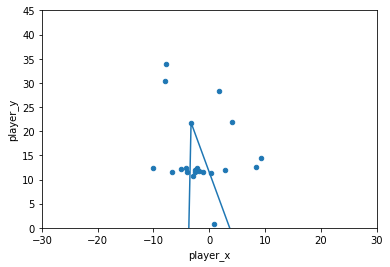

Nombre de défenseurs dans le cône : 4


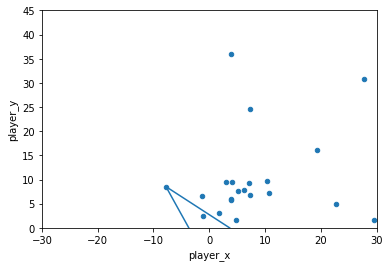

Nombre de défenseurs dans le cône : 1


In [48]:
import matplotlib.pyplot as plt

for id in (
    shots.loc[:, "shot_id"].value_counts().reset_index().loc[:, "index"].iloc[0:3]
):
    (
        shots.query("shot_id == '" + id + "'").pipe(
            plot_shot, xlim=(-30, 30), ylim=(0, 45)
        )
    )
    plt.show()
    print(
        "Nombre de défenseurs dans le cône : "
        + str(
            shots.query("shot_id == '" + id + "'")
            .query("is_defender")
            .loc[:, "in_cone"]
            .sum()
        )
    )


On calcule maintenant le nombre de défenseurs dans le cône de tir pour chaque tir

In [49]:
shots = (
    shots.reset_index(drop=True)
    .groupby("shot_id")
    .apply(
        lambda df1: (
            df1.assign(
                nb_def_in_cone=lambda df2: df2.query("is_defender")
                .loc[:, "in_cone"]
                .sum()
            )
        )
    )
)

shots.head(44)

player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                       
001_1_1102 0   19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1   34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2   16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3   19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4   11.866742     15.13  Player_0035     Team_02  001_1_1102   1   
           5    3.256742      2.03  Player_0034     Team_02  001_1_1102   1   
           6   15.516742     10.72  Player_0030     Team_02  001_1_1102   1   
           7   13.926742      9.71  Player_0063     Team_02  001_1_1102   1   
           8   47.736742      2.10  Player_0060     Team_02  001_1_1102   1   
           9   11.526742      4.52  Player_0036     Team_02  001_1_1102   1   
           10  14.166742     -8.06  Player_0070     Team_02  001_1_1102   1   
           11  21.866742     27.03  Player_0021     Team_01  001_1_1102   1   
           12  51.726742     10.00  Player_0067     Team_01  001_1_1102   1   
           13  83.206742      3.22  Player_0040     Team_01  001_1_1102   1   
           14  12.276742      5.36  Player_0087     Team_01  001_1_1102   1   
           15  29.606742      2.08  Player_0079     Team_01  001_1_1102   1   
           16  18.446742    -17.93  Player_0010     Team_01  001_1_1102   1   
           17  15.726742     11.72  Player_0044     Team_01  001_1_1102   1   
           18  42.276742     17.83  Player_0025     Team_01  001_1_1102   1   
           19  53.626742     -1.80  Player_0005     Team_01  001_1_1102   1   
           20   9.466742     16.48  Player_0092     Team_01  001_1_1102   1   
           21  52.476742    -13.84  Player_0090     Team_01  001_1_1102   1   
001_1_1231 22  37.612551     11.69  Player_0088     Team_02  001_1_1231   1   
           23  12.582551     15.75  Player_0029     Team_02  001_1_1231   1   
           24  28.752551     -1.46  Player_0056     Team_02  001_1_1231   1   
           25  14.072551     -6.58  Player_0004     Team_02  001_1_1231   1   
           26  38.392551    -13.05  Player_0035     Team_02  001_1_1231   1   
           27  78.492551      1.54  Player_0034     Team_02  001_1_1231   1   
           28  34.712551     22.29  Player_0030     Team_02  001_1_1231   1   
           29  50.172551      1.90  Player_0063     Team_02  001_1_1231   1   
           30  15.692551      6.23  Player_0060     Team_02  001_1_1231   1   
           31  50.792551      9.01  Player_0036     Team_02  001_1_1231   1   
           32  14.622551     23.30  Player_0070     Team_02  001_1_1231   1   
           33  10.532551     -0.88  Player_0021     Team_01  001_1_1231   1   
           34  14.062551      6.44  Player_0067     Team_01  001_1_1231   1   
           35   7.822551      3.72  Player_0040     Team_01  001_1_1231   1   
           36  30.032551    -11.20  Player_0087     Team_01  001_1_1231   1   
           37  13.062551     16.12  Player_0079     Team_01  001_1_1231   1   
           38  19.352551     16.94  Player_0010     Team_01  001_1_1231   1   
           39  50.492551      7.49  Player_0044     Team_01  001_1_1231   1   
           40  18.242551      7.42  Player_0025     Team_01  001_1_1231   1   
           41  11.642551     10.79  Player_0005     Team_01  001_1_1231   1   
           42  19.242551      1.25  Player_0092     Team_01  001_1_1231   1   
           43  11.842551     18.20  Player_0090     Team_01  001_1_1231   1   

               min  sec   goal  x_opta  ...  player_dist_to_goal  is_gk  \
shot_id                                 ...                               
001_1_1102 0    18   22  False    85.6  ...            19.754877  False   
           1    18   22  False    85.6  ...            37.394171  False   
           2    18   22  False    85.6  ...            22.157172  False   
      

### angle de vue du tireur 

In [50]:
def angle(x1, y1, x2, y2):
    vec1 = np.array([x1, y1])
    vec2 = np.array([x2, y2])
    return np.arccos(
        np.clip(np.dot(vec1, vec2) / np.linalg.norm(vec1) / np.linalg.norm(vec2), -1, 1)
    )


test = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]
for x, y in test:
    print(angle(1, 0, x, y) / math.pi * 180)


0.0
45.00000000000001
90.0
135.0
180.0
135.0
90.0
45.00000000000001


In [51]:
shots = shots.assign(
    field_of_view=lambda df1: (
        df1.apply(
            lambda df2: angle(
                -3.66 - df2.loc["striker_x"],
                -df2.loc["striker_y",],
                3.66 - df2.loc["striker_x"],
                -df2.loc["striker_y",],
            )
            / math.pi
            * 180,
            axis=1,
        )
    )
)
shots.head(44)


player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                       
001_1_1102 0   19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1   34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2   16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3   19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4   11.866742     15.13  Player_0035     Team_02  001_1_1102   1   
           5    3.256742      2.03  Player_0034     Team_02  001_1_1102   1   
           6   15.516742     10.72  Player_0030     Team_02  001_1_1102   1   
           7   13.926742      9.71  Player_0063     Team_02  001_1_1102   1   
           8   47.736742      2.10  Player_0060     Team_02  001_1_1102   1   
           9   11.526742      4.52  Player_0036     Team_02  001_1_1102   1   
           10  14.166742     -8.06  Player_0070     Team_02  001_1_1102   1   
           11  21.866742     27.03  Player_0021     Team_01  001_1_1102   1   
           12  51.726742     10.00  Player_0067     Team_01  001_1_1102   1   
           13  83.206742      3.22  Player_0040     Team_01  001_1_1102   1   
           14  12.276742      5.36  Player_0087     Team_01  001_1_1102   1   
           15  29.606742      2.08  Player_0079     Team_01  001_1_1102   1   
           16  18.446742    -17.93  Player_0010     Team_01  001_1_1102   1   
           17  15.726742     11.72  Player_0044     Team_01  001_1_1102   1   
           18  42.276742     17.83  Player_0025     Team_01  001_1_1102   1   
           19  53.626742     -1.80  Player_0005     Team_01  001_1_1102   1   
           20   9.466742     16.48  Player_0092     Team_01  001_1_1102   1   
           21  52.476742    -13.84  Player_0090     Team_01  001_1_1102   1   
001_1_1231 22  37.612551     11.69  Player_0088     Team_02  001_1_1231   1   
           23  12.582551     15.75  Player_0029     Team_02  001_1_1231   1   
           24  28.752551     -1.46  Player_0056     Team_02  001_1_1231   1   
           25  14.072551     -6.58  Player_0004     Team_02  001_1_1231   1   
           26  38.392551    -13.05  Player_0035     Team_02  001_1_1231   1   
           27  78.492551      1.54  Player_0034     Team_02  001_1_1231   1   
           28  34.712551     22.29  Player_0030     Team_02  001_1_1231   1   
           29  50.172551      1.90  Player_0063     Team_02  001_1_1231   1   
           30  15.692551      6.23  Player_0060     Team_02  001_1_1231   1   
           31  50.792551      9.01  Player_0036     Team_02  001_1_1231   1   
           32  14.622551     23.30  Player_0070     Team_02  001_1_1231   1   
           33  10.532551     -0.88  Player_0021     Team_01  001_1_1231   1   
           34  14.062551      6.44  Player_0067     Team_01  001_1_1231   1   
           35   7.822551      3.72  Player_0040     Team_01  001_1_1231   1   
           36  30.032551    -11.20  Player_0087     Team_01  001_1_1231   1   
           37  13.062551     16.12  Player_0079     Team_01  001_1_1231   1   
           38  19.352551     16.94  Player_0010     Team_01  001_1_1231   1   
           39  50.492551      7.49  Player_0044     Team_01  001_1_1231   1   
           40  18.242551      7.42  Player_0025     Team_01  001_1_1231   1   
           41  11.642551     10.79  Player_0005     Team_01  001_1_1231   1   
           42  19.242551      1.25  Player_0092     Team_01  001_1_1231   1   
           43  11.842551     18.20  Player_0090     Team_01  001_1_1231   1   

               min  sec   goal  x_opta  ...  is_gk is_opposing_gk  \
shot_id                                 ...                         
001_1_1102 0    18   22  False    85.6  ...  False          False   
           1    18   22  False    85.6  ...  False          False   
           2    18   22  False    85.6  ...  False          False   
           3    18   22  False    85

on ajoute l'angle du tireur par rapport à l'axe Y :

In [52]:
shots = shots.assign(
    striker_angle=lambda df1: (
        df1.apply(
            lambda df2: angle(0, 1, df2.loc["striker_x"], df2.loc["striker_y",])
            / math.pi
            * 180,
            axis=1,
        )
    )
)
shots.head(44)


player_y  player_x    player_id player_team     shot_id  ht  \
shot_id                                                                       
001_1_1102 0   19.276742      4.32  Player_0088     Team_02  001_1_1102   1   
           1   34.856742    -13.54  Player_0029     Team_02  001_1_1102   1   
           2   16.666742     14.60  Player_0056     Team_02  001_1_1102   1   
           3   19.156742     25.32  Player_0004     Team_02  001_1_1102   1   
           4   11.866742     15.13  Player_0035     Team_02  001_1_1102   1   
           5    3.256742      2.03  Player_0034     Team_02  001_1_1102   1   
           6   15.516742     10.72  Player_0030     Team_02  001_1_1102   1   
           7   13.926742      9.71  Player_0063     Team_02  001_1_1102   1   
           8   47.736742      2.10  Player_0060     Team_02  001_1_1102   1   
           9   11.526742      4.52  Player_0036     Team_02  001_1_1102   1   
           10  14.166742     -8.06  Player_0070     Team_02  001_1_1102   1   
           11  21.866742     27.03  Player_0021     Team_01  001_1_1102   1   
           12  51.726742     10.00  Player_0067     Team_01  001_1_1102   1   
           13  83.206742      3.22  Player_0040     Team_01  001_1_1102   1   
           14  12.276742      5.36  Player_0087     Team_01  001_1_1102   1   
           15  29.606742      2.08  Player_0079     Team_01  001_1_1102   1   
           16  18.446742    -17.93  Player_0010     Team_01  001_1_1102   1   
           17  15.726742     11.72  Player_0044     Team_01  001_1_1102   1   
           18  42.276742     17.83  Player_0025     Team_01  001_1_1102   1   
           19  53.626742     -1.80  Player_0005     Team_01  001_1_1102   1   
           20   9.466742     16.48  Player_0092     Team_01  001_1_1102   1   
           21  52.476742    -13.84  Player_0090     Team_01  001_1_1102   1   
001_1_1231 22  37.612551     11.69  Player_0088     Team_02  001_1_1231   1   
           23  12.582551     15.75  Player_0029     Team_02  001_1_1231   1   
           24  28.752551     -1.46  Player_0056     Team_02  001_1_1231   1   
           25  14.072551     -6.58  Player_0004     Team_02  001_1_1231   1   
           26  38.392551    -13.05  Player_0035     Team_02  001_1_1231   1   
           27  78.492551      1.54  Player_0034     Team_02  001_1_1231   1   
           28  34.712551     22.29  Player_0030     Team_02  001_1_1231   1   
           29  50.172551      1.90  Player_0063     Team_02  001_1_1231   1   
           30  15.692551      6.23  Player_0060     Team_02  001_1_1231   1   
           31  50.792551      9.01  Player_0036     Team_02  001_1_1231   1   
           32  14.622551     23.30  Player_0070     Team_02  001_1_1231   1   
           33  10.532551     -0.88  Player_0021     Team_01  001_1_1231   1   
           34  14.062551      6.44  Player_0067     Team_01  001_1_1231   1   
           35   7.822551      3.72  Player_0040     Team_01  001_1_1231   1   
           36  30.032551    -11.20  Player_0087     Team_01  001_1_1231   1   
           37  13.062551     16.12  Player_0079     Team_01  001_1_1231   1   
           38  19.352551     16.94  Player_0010     Team_01  001_1_1231   1   
           39  50.492551      7.49  Player_0044     Team_01  001_1_1231   1   
           40  18.242551      7.42  Player_0025     Team_01  001_1_1231   1   
           41  11.642551     10.79  Player_0005     Team_01  001_1_1231   1   
           42  19.242551      1.25  Player_0092     Team_01  001_1_1231   1   
           43  11.842551     18.20  Player_0090     Team_01  001_1_1231   1   

               min  sec   goal  x_opta  ...  is_opposing_gk dist_to_striker  \
shot_id                                 ...                                   
001_1_1102 0    18   22  False    85.6  ...           False        8.207466   
           1    18   22  False    85.6  ...           False       31.686346   
           2    18   22  False    85.6  ...           False      

### Valeur absolue de x

In [56]:
shots.loc[:, "x_abs"] = abs(shots.loc[:, "player_x"])


# Ultime filtrage

On se débarrasse de toutes les lignes & colonnes inutiles :

In [57]:
print(sorted(list(shots.columns)))
drop = ["x_opta",
            "y_opta",
            "striker_id",
            "striker_team",
            "inverted",
            "half_field",
            "striker_x",
            "striker_y",
            "player_theta",
            "is_gk",
            "is_opposing_gk",
            "dist_to_striker",
            "is_defender",
            "in_cone"]
remaining = ["shot_id",
             "x_abs"
            "player_id",
            "player_team",
            "match_id",
            "ht",
            "min",
            "sec",
            "time_sec",
            "player_x",
            "player_y",
            "player_dist_to_goal",
            "striker_angle",
            "field_of_view",
            "dist_st_to_gk",
            "closest_def",
            "nb_def_in_cone",
            "density",
            "goal"]
print(sorted(drop + remaining))

['closest_def', 'density', 'dist_st_to_gk', 'dist_to_striker', 'field_of_view', 'goal', 'half_field', 'ht', 'in_cone', 'inverted', 'is_defender', 'is_gk', 'is_opposing_gk', 'match_id', 'min', 'nb_def_in_cone', 'player_dist_to_goal', 'player_id', 'player_team', 'player_theta', 'player_x', 'player_y', 'sec', 'shot_id', 'striker_angle', 'striker_id', 'striker_team', 'striker_x', 'striker_y', 'time_sec', 'x_abs', 'x_opta', 'y_opta']
['closest_def', 'density', 'dist_st_to_gk', 'dist_to_striker', 'field_of_view', 'goal', 'half_field', 'ht', 'in_cone', 'inverted', 'is_defender', 'is_gk', 'is_opposing_gk', 'match_id', 'min', 'nb_def_in_cone', 'player_dist_to_goal', 'player_team', 'player_theta', 'player_x', 'player_y', 'sec', 'shot_id', 'striker_angle', 'striker_id', 'striker_team', 'striker_x', 'striker_y', 'time_sec', 'x_absplayer_id', 'x_opta', 'y_opta']


In [58]:
shots = (
    shots.query("player_id == striker_id")
    .reset_index(drop=True)
    .drop(
        [
            "x_opta",
            "y_opta",
            "striker_id",
            "striker_team",
            "inverted",
            "half_field",
            "striker_x",
            "striker_y",
            "player_theta",
            "is_gk",
            "is_opposing_gk",
            "dist_to_striker",
            "is_defender",
            "in_cone",
        ],
        axis=1,
    )
    .reindex(
        columns=[
            "shot_id",
            "player_id",
            "player_team",
            "match_id",
            "ht",
            "min",
            "sec",
            "time_sec",
            "player_x",
            "player_y",
            "dist_st_to_gk",
            "player_dist_to_goal",
            "field_of_view",
            "x_abs",
            "striker_angle",
            "nb_def_in_cone",
            "closest_def",
            "density",
            "goal",
        ]
    )
    .rename(
        columns={
            "player_id": "player",
            "player_team": "team",
            "match_id": "match",
            "player_x": "x",
            "player_y": "y",
            "player_dist_to_goal": "dist_to_goal",
            "striker_angle": "angle_to_y",
            "dist_st_to_gk": "dist_to_gk",
        }
    )
)

shots.head()
with open("train.pkl", "wb") as file:
    pickle.dump(shots, file)